--- 

Reproduce the results from:

Abi Jaber, Illand, and Li (2023). *[The quintic Ornstein-Uhlenbeck volatility model that jointly
calibrates SPX & VIX smiles](https://arxiv.org/pdf/2212.10917)*

---

In [25]:
# TODO:
# - change implementation, simulate normal at each step with antithetic if needed.

# Imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import quintic
import quintic_base
from scipy import integrate, interpolate

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)
SEED = 1234

## The quintic Ornstein-Uhlenbeck model

$$
\begin{aligned}
    \frac{dS_t}{S_t} &= \sigma_t dW_t^S,  \\
    \\
    \sigma_t &= \sqrt{\xi_0(t)}\frac{p(X_t)}{\sqrt{\mathbb E \left[p(X_t)^2\right]}}, 
    \quad p(x) =\alpha_0 + \alpha_1 x + \alpha_3 x^3 + \alpha_5 x^5,
    \\
    X_t &= \varepsilon^{H-\frac12} \int_0^t e^{-(\frac12-H)\varepsilon^{-1}(t-s)} \, dW_s,
    \quad \varepsilon > 0,
\end{aligned}
$$

where $W$ and $W^S$ are correlated Brownian motions with correlation $\rho$.

## Sanity checks

We check the formula for $\mathbb{E}[p(Z)^2]$ where 
$Z \sim \mathcal{N}\left(\mu, \sigma^2\right)$

In [16]:
a0, a1, a3, a5 = np.abs(np.random.randn(4))
mu = np.random.randn()
sig = np.abs(np.random.randn())
n_quad = 20
estim = quintic.mean_px_squared(
    a0=a0, a1=a1, a3=a3, a5=a5, mu=mu, sig=sig, n_quad=n_quad
)
theoretical = quintic.mean_px_squared(a0=a0, a1=a1, a3=a3, a5=a5, mu=mu, sig=sig)

n_mc = 2 * 10**6
normal = mu + sig * np.random.randn(n_mc)
monte_carlo = np.mean((a0 + a1 * normal + a3 * normal**3 + a5 * normal**5) ** 2)

print(f"Quadrature value: {estim:.5f}")
print(f"MC estimate:      {monte_carlo:.5f}")
print(f"Theoretical value:   {theoretical:.5f}")


def quintic_poly(x):
    return a0 + a1 * x + a3 * x**3 + a5 * x**5


def integrand(x):
    return (quintic_poly(mu + sig * x)) ** 2 * np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)


integral = integrate.quad(integrand, -np.inf, np.inf)
print(f"Scipy integral:   {integral[0]:.5f}")

Quadrature value: 146.20338
MC estimate:      146.28980
Theoretical value:   146.20338
Scipy integral:   146.20338


Comparison Shaun's code and our code

In [4]:
T = 1 / 12
n_steps = 200
params = {
    "rho": -0.65,
    "H": -0.1,
    "eps": 1 / 52,
    "a_vec": [0.01, 1, 0.214, 0.227],
}
rho, H, eps, a_vec = (
    params["rho"],
    params["H"],
    params["eps"],
    params["a_vec"],
)
eta_tild = eps ** (H - 0.5)
kappa_tild = (0.5 - H) / eps
a_0, a_1, a_3, a_5 = a_vec
a_k = np.array([a_0, a_1, 0.0, a_3, 0.0, a_5])
n = len(a_k)
tt = np.linspace(0.0, T, n_steps + 1)
std_X_t = np.sqrt(eta_tild**2 / (2 * kappa_tild) * (1 - np.exp(-2 * kappa_tild * tt)))
cauchy_product = np.convolve(a_k, a_k)
normal_var = np.sum(
    cauchy_product[np.arange(0, 2 * n, 2)].reshape(-1, 1)
    * std_X_t ** (np.arange(0, 2 * n, 2).reshape(-1, 1))
    * np.array(
        [quintic_base.doublefactorial(z) for z in np.arange(0, 2 * n, 2) - 1]
    ).reshape(-1, 1),
    axis=0,
)

In [5]:
sig = quintic.std_x_ou_quintic(params, t=tt)
normal_var_closed_form = quintic.mean_px_squared(a_0, a_1, a_3, a_5, sig=sig)

In [6]:
assert np.allclose(normal_var, normal_var_closed_form)

Compute correlation between

$$
    \delta X_i = \varepsilon^{H-1/2} \int_{t_i}^{t_{i+1}} e^{-(\frac12-H)\varepsilon^{-1}s} \, dW_s
$$

and 

$$
    \delta W_i = \int_{t_i}^{t_{i+1}} dW_s = W_{t_{i+1}} - W_{t_i}
$$

In [7]:
eps = 1e-2
n_steps = 200
T = 1
H = -0.1
t_grid = np.linspace(0, T, n_steps + 1)

In [9]:
# cov dX dW
cov_dX_dW = np.exp(((0.5 - H) / eps) * t_grid[1:]) - np.exp(
    ((0.5 - H) / eps) * t_grid[:-1]
)
cov_dX_dW *= eps ** (0.5 + H) / (0.5 - H)

# var dX
var_dX = (eps ** (2 * H) / (1 - 2 * H)) * (
    np.exp(((1 - 2 * H) / eps) * t_grid[1:]) - np.exp(((1 - 2 * H) / eps) * t_grid[:-1])
)

# var dW
var_dW = t_grid[1:] - t_grid[:-1]


# correlation
rho_dX_dW = cov_dX_dW / np.sqrt(var_dX * var_dW)

rho_dX_dW[:4]

array([0.99627651, 0.99627651, 0.99627651, 0.99627651])

## SPX call/put options by Monte Carlo with antithetic and control variates

Recall $X_t = \varepsilon^{H-\frac12} \int_0^t e^{-(\frac12-H)\varepsilon^{-1}(t-s)} \, dW_s$

Consider $t_k = k \Delta $, $k=0, \ldots, n$, with $\Delta  = T/n$.

Then, we have the recursion

$$
    X_{t_k} 
    = \varepsilon^{H-\frac12} \int_0^{t_k} e^{-(\frac12-H)\varepsilon^{-1}(t_k-s)} \, dW_s
    = e^{-(\frac12-H)\varepsilon^{-1}\Delta} X_{t_{k-1}} + \delta X_k,
$$

where

$$
\delta X_k = \varepsilon^{H-\frac12} \int_{t_{k-1}}^{t_k} e^{-(\frac12-H)\varepsilon^{-1}(t_k-s)} \, dW_s
\sim \mathcal N \left(0, \mathbb{E}[\delta X_k^2]\right).
$$

and 

$$
\mathbb{E}[\delta X_k^2] = \frac{\varepsilon^{2H}}{1-2H}\left(1 - e^{-(1-2H)\varepsilon^{-1}\Delta}\right).
$$

We need to compute the covariance between $\delta X_k$ 
and $\delta W_k^S = \int_{t_{k-1}}^{t_k} dW_s^S = W_{t_k}^S - W_{t_{k-1}}^S \sim \mathcal N \left(0, \Delta\right)$.


It is given by

$$
\mathbb{E}[\delta X_k \, \delta W_k^S]
= \rho \varepsilon^{H-\frac12} \int_{t_{k-1}}^{t_k} e^{-(\frac12-H)\varepsilon^{-1}(t_k-s)} \, ds
= \rho \frac{\varepsilon^{H+\frac12}}{\frac12-H}\left(1 - e^{-(\frac12-H)\varepsilon^{-1}\Delta}\right).
$$

---

VIX simulation

By definition, 

$$
\mathrm{VIX}_T^2
= \frac{1}{\Delta} \int_T^{T+\Delta} \xi_T(u) \, du
$$

where $\xi_T(u) = \mathbb{E}[\sigma_u^2 | \mathcal{F}_T]$.

Observe that

$$
    X_u = X_T e^{-(\frac12-H)\varepsilon^{-1}(u-T)} + \varepsilon^{H-\frac12} \int_T^u e^{-(\frac12-H)\varepsilon^{-1}(u-s)} \, dW_s.
$$

Hence, conditionnally on $\mathcal{F}_T$, $X_u$ is Gaussian with mean 
$$
\mathbb{E}[X_u | \mathcal{F}_T] = X_T e^{-(\frac12-H)\varepsilon^{-1}(u-T)}
$$
and variance
$$
\mathrm{Var}[X_u | \mathcal{F}_T]
= \frac{\varepsilon^{2H}}{1-2H}\left(1 - e^{-(1-2H)\varepsilon^{-1}(u-T)}\right).   
$$

Recall that $X_T$ is a centered normal random variable with variance
$$
\mathrm{Var}[X_T] = \frac{\varepsilon^{2H}}{1-2H}\left(1 - e^{-(1-2H)\varepsilon^{-1}T}\right).
$$

Denote $f(\mu,\sigma) = E[p(Z)^2]$ where $Z \sim N(\mu,\sigma^2)$

Then, we have

$$
    \xi_T(u)
    = \mathbb{E}[\sigma_u^2 | \mathcal{F}_T]
    = \xi_0(u) \mathbb{E}\left[\frac{p(X_u)^2}{\mathbb{E}[p(X_u)^2]} \middle| \mathcal{F}_T\right]
    = \xi_0(u) \frac{f\left(\mu_{X_u | \mathcal{F}_T}, \sigma_{X_u | \mathcal{F}_T}\right)}{f(0, \sigma_{X_u})},
$$

In [17]:
np.random.seed(SEED)
n_steps = 600
n_mc = 5 * 10**4
S0 = 1.0
T = 1 / 12
ks = np.linspace(-0.2, 0.03, 50)  # log-moneyness
Ks = np.exp(ks) * S0  # strikes

In [18]:
params = {
    "rho": -0.65,
    "H": -0.1,
    "eps": 1 / 52,
    "a_vec": [0.01, 1, 0.214, 0.227],
}

In [19]:
w1 = quintic_base.gen_bm_path(n_steps, n_mc)
w1 = np.insert(w1, 0, 0, axis=0)  # W_0 = 0
T_array_nodes = np.array([0, 0.03, 1 / 12, 2 / 12, 3 / 12, 6 / 12, 12 / 12, 24 / 12])
fv_nodes = np.ones_like(T_array_nodes) * 0.02  # fix fwd variance at 0.02
res = quintic_base.mc_polynomial_fwd_var(
    params=params,
    T=T,
    S0=S0,
    Ks=Ks,
    n_steps=n_steps,
    n_mc=n_mc,
    fv_nodes=fv_nodes,
    T_array_nodes=T_array_nodes,
    w1=w1,
)

In [20]:
# p_mc, std_mc, imp_mc, imp_mc_upper, imp_mc_lower = quintic.mc_polynomial_fwd_var(
#     params=params,
#     T=T,
#     S0=S0,
#     Ks=Ks,
#     n_steps=n_steps,
#     n_mc=n_mc,
#     fv_nodes=fv_nodes,
#     T_array_nodes=T_array_nodes,
#     w1=w1,
# )

In [23]:
impvols = quintic.simulate_quintic_ou(
    params=params,
    xi0=lambda t: 0.02 * np.ones_like(t),
    T=T,
    k=ks,
    n_steps=n_steps,
    n_mc=n_mc,
    seed=SEED,
    antithetic=True,
)

In [20]:
# S_T = quintic.simulate_quintic_ou(
#     params=params,
#     xi0=lambda t: 0.02 * np.ones_like(t),
#     T=T,
#     k=ks,
#     n_steps=n_steps,
#     n_mc=n_mc,
#     seed=SEED,
#     antithetic=False,
#     return_paths=True,
# )

In [58]:
# from black import black_impvol

# iv_direct = np.zeros_like(Ks)
# for i, K in enumerate(Ks):
#     if K < 1.0:
#         price = np.mean(np.maximum(K - S_T, 0))
#         iv_direct[i] = black_impvol(F=S0, K=K, T=T, value=price, opttype=-1)
#     else:
#         price = np.mean(np.maximum(S_T - K, 0))
#         iv_direct[i] = black_impvol(F=S0, K=K, T=T, value=price, opttype=1)

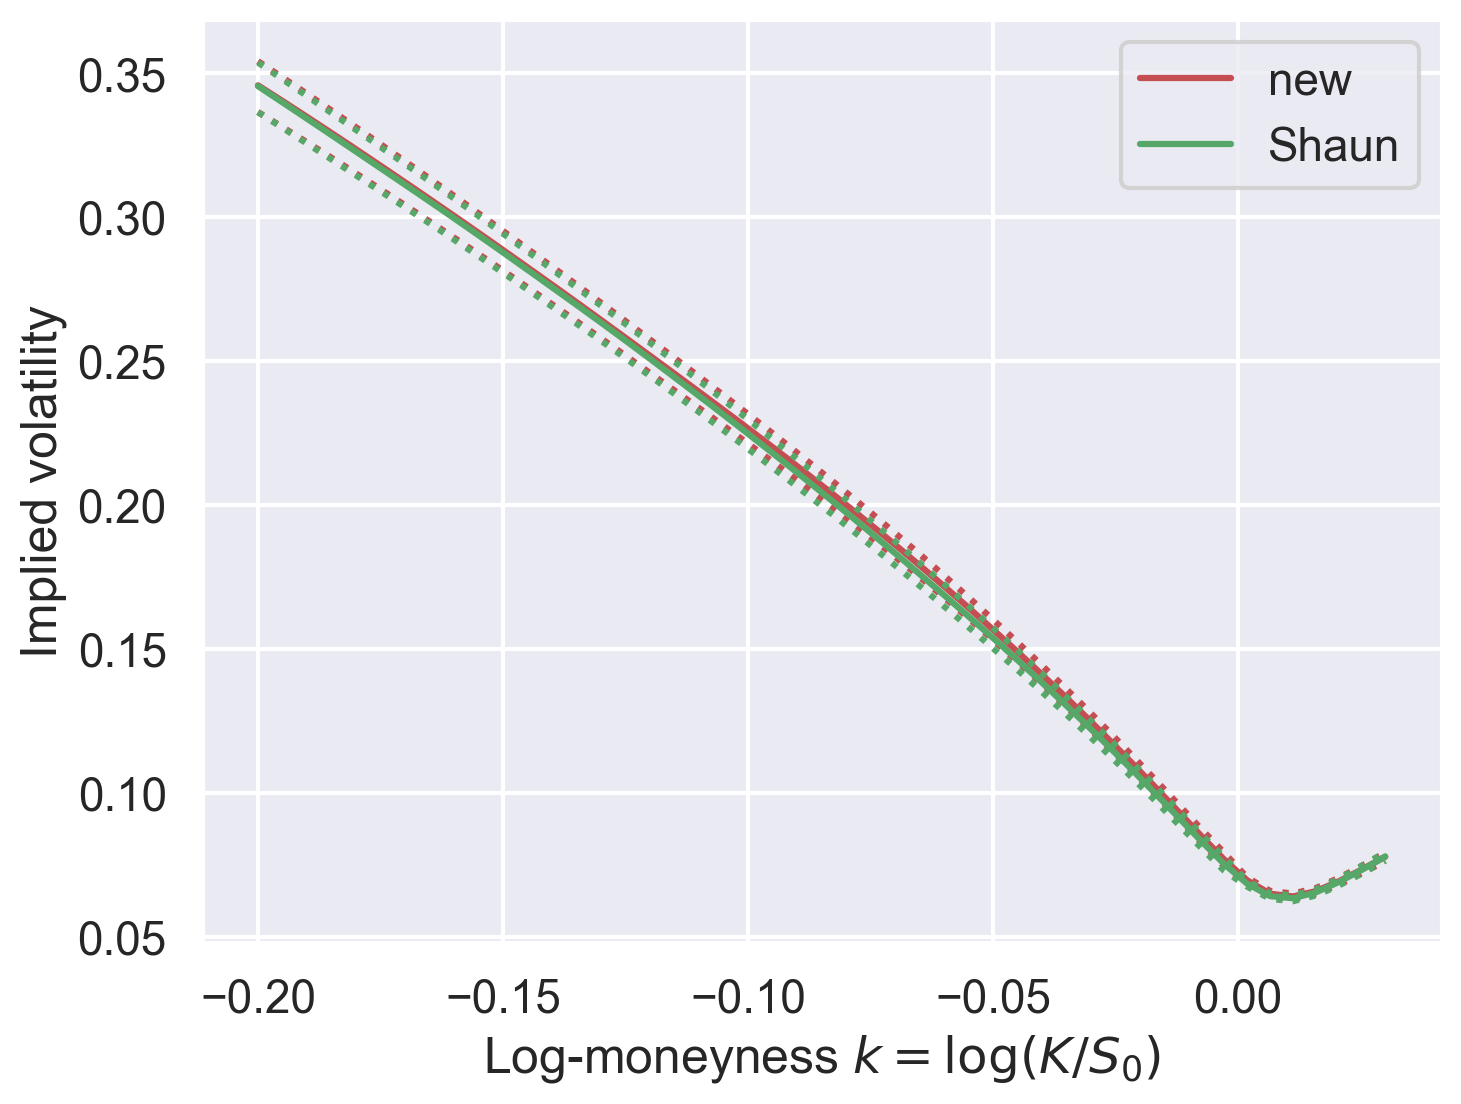

In [24]:
fig, ax = plt.subplots()
ax.plot(ks, impvols["otm_impvol"], "r-", label="new")
ax.plot(ks, impvols["otm_impvol_high"], ":r")
ax.plot(ks, impvols["otm_impvol_low"], ":r")
ax.plot(ks, res["otm_impvol"], "g-", label="Shaun")
ax.plot(ks, res["otm_impvol_high"], ":g")
ax.plot(ks, res["otm_impvol_low"], ":g")
ax.set_xlabel(r"Log-moneyness $k = \log(K/S_0)$")
ax.set_ylabel("Implied volatility")
ax.legend()
plt.show()

## VIX call/put options by Gaussian quadrature

In [13]:
# gaussian quadrature
deg_vix = 800
x_org_vix, w_org_vix = np.polynomial.legendre.leggauss(deg_vix)
lb_vix = -8
ub_vix = 8

In [14]:
lm_vix = np.linspace(-0.1, 1, 50)
vix_strike_perc = np.exp(lm_vix)

In [15]:
vix_fut, vix_call, vix_iv = quintic.vix_all_integration_poly_fast_revert_model(
    H, eps, T, a_k_part, x_org_vix, w_org_vix, vix_strike_perc, fv_nodes, T_array_nodes
)

NameError: name 'pi' is not defined

In [ ]:
plt.plot(vix_strike_perc * vix_fut, vix_iv, label="VIX iv")
plt.axvline(x=vix_fut, color="black", label="VIX future")
plt.legend()
plt.show()